In [1]:
import mido
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

from tqdm import tqdm


In [2]:
print(__name__)

__main__


In [2]:
"""
To Do:

Implement sustain in midi_to_pandas
"""

'\nTo Do:\n\nImplement sustain in midi_to_pandas\n'

In [3]:
"""
Create Map of midi note values to western note system
"""

notes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

midi_range = range(129)

midi_range_map = {i: (notes * 12)[i] + str((i - 12) // 12) for i in midi_range}

In [4]:
elise = mido.MidiFile("src/data/midi_examples/fuer_elise.mid")

In [5]:
for i, track in enumerate(elise.tracks):
    print("Track {}: {}".format(i, track.name))
    for msg in track[:40]:
        if not msg.is_meta:
            print(f"\t{msg}")

Track 0: 
Track 1: Piano RH
	control_change channel=0 control=0 value=0 time=0
	program_change channel=0 program=0 time=0
	control_change channel=0 control=7 value=127 time=0
	control_change channel=0 control=10 value=94 time=0
	pitchwheel channel=0 pitch=0 time=2
	control_change channel=0 control=11 value=127 time=4
	control_change channel=0 control=1 value=0 time=6
	note_on channel=0 note=76 velocity=120 time=4
	note_off channel=0 note=76 velocity=64 time=92
	note_on channel=0 note=75 velocity=120 time=6
	note_off channel=0 note=75 velocity=64 time=94
	note_on channel=0 note=76 velocity=120 time=0
	note_off channel=0 note=76 velocity=64 time=92
	note_on channel=0 note=75 velocity=120 time=6
	note_off channel=0 note=75 velocity=64 time=94
	note_on channel=0 note=76 velocity=120 time=2
	note_off channel=0 note=76 velocity=64 time=94
	note_on channel=0 note=71 velocity=120 time=0
	control_change channel=0 control=64 value=127 time=12
	note_off channel=0 note=71 velocity=64 time=80
	note

In [38]:
def get_timing(midifile):
    track0 = elise.tracks[0]
    for msg in track0:

        # get clocks per click
        if str(msg).split()[2] == "time_signature":
            clocks_per_click = int(str(msg).split()[5].split("=")[1])
            print(msg)
        
        # get initial tempo
        if str(msg).split()[2] == "set_tempo":
            print(msg)
            tempo = int(str(msg).split()[3].split("=")[1])
            break
    
    return(tempo, clocks_per_click, )

tempo, cpc = get_timing(elise)

# tempo is microseconds per beat (quarter note), clicks per clock is ticks per quarter note, so
seconds_per_beat = tempo / 1000000
seconds_per_tick = seconds_per_beat / cpc

# check my understanding
print(tempo, cpc)
print(seconds_per_beat)
print(mido.tick2second(1, cpc, tempo))
print(seconds_per_tick)

<meta message time_signature numerator=3 denominator=8 clocks_per_click=96 notated_32nd_notes_per_beat=8 time=0>
<meta message set_tempo tempo=800000 time=0>
800000 96
0.8
0.008333333333333333
0.008333333333333333


In [7]:
"""
Parsing msg to dict
"""

def msg_to_dict(msg):
#    print(msg)
    if str(msg)[0] == "<":
        msg = str(msg)[1:-1]
    else:
        msg = str(msg)

    msg_list = msg.split()
    
    msg_dict = {}
    msg_dict["type_1"] = msg_list[0]
    del msg_list[0]

    if msg_dict["type_1"] == "meta":
        msg_dict["type_2"] = msg_list[0]
        msg_dict["type_3"] = msg_list[1]
        del msg_list[:2]
    
#    print(msg_list)
#    print(msg_dict)
    
    def try_int(char):
        try:
            cast = int(char)
        except (ValueError):
            cast = str(char)
        return(cast)
    
    if msg_dict["type_1"] == "meta":
        if msg_dict["type_3"] in ["sequencer_specific", "track_name"]:
#            print(msg_dict, "\n----------")
            return(msg_dict)
    
    else:
        msg_dict.update({item.split('=')[0]: try_int(item.split('=')[1]) for item in msg_list})

#        print(msg_dict, "\n----------")
    
    return(msg_dict)
    
for track in elise.tracks:
    for msg in track:
        msg_to_dict(msg)

In [18]:
"""
Parsing midi to df
"""

def midi_to_pandas(midi, include_meta=True, sustain=False):
    _df = pd.DataFrame({})
    
    for i, track in tqdm(enumerate(elise.tracks)):
        for msg in track:
            if not include_meta and msg.is_meta:
                continue

            msg = msg_to_dict(msg)

            msg['track'] = i

            _df = _df.append(msg, ignore_index=True)
    
    # add column with western note names
    def note_map(note):
        if np.isnan(note):
            return np.nan
        
        else:
            return midi_range_map[note]

    _df["note_name"] = _df["note"].apply(note_map)
    
    # adding absolute times
    tempo, cpc = get_timing(midi)
    
    _df['total_time'] = _df.groupby('track')['time'].transform(pd.Series.cumsum)
    _df['total_time_seconds'] = _df['total_time'].apply(lambda x: mido.tick2second(x, cpc, tempo))
    
    # adding column for duration of notes
    _df["duration"] = np.nan

    for i in tqdm(_df[_df["type_1"] == "note_on"].index):
        total_time, note, track, channel = _df[["total_time", "note", "track", "channel"]].iloc[i].values
        
        _df.loc[i, "duration"] = _df[
            (_df["total_time"] > total_time) & (_df["note"] == note) &
            (_df["track"] == track) & (_df["channel"] == channel)
        ]["total_time"].iloc[0] - total_time
    
    _df["duration_seconds"] = _df['duration'].apply(lambda x: mido.tick2second(x, cpc, tempo))
    
    
    if sustain:
        pass # TODO: implement
    
    return _df

In [19]:
elise_df = midi_to_pandas(elise)
elise_df

5it [00:34,  6.96s/it]
  1%|▏         | 30/2102 [00:00<00:06, 297.43it/s]

<meta message time_signature numerator=3 denominator=8 clocks_per_click=96 notated_32nd_notes_per_beat=8 time=0>
<meta message set_tempo tempo=800000 time=0>


100%|██████████| 2102/2102 [00:06<00:00, 328.41it/s]


,track,type_1,type_2,type_3,channel,control,time,value,program,pitch,note,velocity,note_name,total_time,total_time_seconds,duration,duration_seconds
0,0.0,meta,message,time_signature,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,meta,message,sequencer_specific,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,meta,message,set_tempo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,meta,message,set_tempo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,meta,message,set_tempo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4882,4.0,note_on,NaN,NaN,13.0,NaN,292.0,NaN,NaN,NaN,33.0,120.0,A1,71632.0,596.933333,380.0,3.166667
4883,4.0,note_on,NaN,NaN,13.0,NaN,2.0,NaN,NaN,NaN,45.0,120.0,A2,71634.0,596.950000,382.0,3.183333
4884,4.0,note_off,NaN,NaN,13.0,NaN,378.0,NaN,NaN,NaN,33.0,64.0,A1,72012.0,600.100000,NaN,NaN
4885,4.0,note_off,NaN,NaN,13.0,NaN,4.0,NaN,NaN,NaN,45.0,64.0,A2,72016.0,600.133333,NaN,NaN


In [20]:
elise_df.groupby(by=["type_1", "channel", "track"]).count()

type_2  type_3  control  time  value  program  \
type_1         channel track                                                  
control_change 0.0     1.0         0       0      223   223    223        0   
               1.0     2.0         0       0      223   223    223        0   
               12.0    3.0         0       0        6     6      6        0   
               13.0    4.0         0       0        8     8      8        0   
note_off       0.0     1.0         0       0        0   611      0        0   
               1.0     2.0         0       0        0   440      0        0   
               12.0    3.0         0       0        0   611      0        0   
               13.0    4.0         0       0        0   440      0        0   
note_on        0.0     1.0         0       0        0   611      0        0   
               1.0     2.0         0       0        0   440      0        0   
               12.0    3.0         0       0        0   611      0        0   
               13.0    4.0         0       0        0   440      0        0   
pitchwheel     0.0     1.0         0       0        0     1      0        0   
               1.0     2.0         0       0        0     1      0        0   
               12.0    3.0         0       0        0     1      0        0   
               13.0    4.0         0       0        0     1      0        0   
program_change 0.0     1.0         0       0        0     1      0        1   
               1.0     2.0         0       0        0     1      0        1   
               12.0    3.0         0       0        0     1      0        1   
               13.0    4.0         0       0        0     1      0        1   

                              pitch  note  velocity  note_name  total_time  \
type_1         channel track                                                 
control_change 0.0     1.0        0     0         0          0         223   
               1.0     2.0        0     0         0          0         223   
               12.0    3.0        0     0         0          0           6   
               13.0    4.0        0     0         0          0           8   
note_off       0.0     1.0        0   611       611        611         611   
               1.0     2.0        0   440       440        440         440   
               12.0    3.0        0   611       611        611         611   
               13.0    4.0        0   440       440        440         440   
note_on        0.0     1.0        0   611       611        611         611   
               1.0     2.0        0   440       440        440         440   
               12.0    3.0        0   611       611        611         611   
               13.0    4.0        0   440       440        440         440   
pitchwheel     0.0     1.0        1     0         0          0           1   
               1.0     2.0        1     0         0          0           1   
               12.0    3.0        1     0         0          0           1   
               13.0    4.0        1     0         0          0           1   
program_change 0.0     1.0        0     0         0          0           1   
               1.0     2.0        0     0         0          0           1   
               12.0    3.0        0     0         0          0           1   
               13.0    4.0        0     0         0          0           1   

                              total_time_seconds  duration  duration_seconds  
type_1         channel track                                                  
control_change 0.0     1.0                   223         0                 0  
               1.0     2.0                   223         0                 0  
               12.0    3.0                     6         0                 0  
               13.0    4.0                     8         0                 0  
note_off       0.0     1.0                   611         0                 0  
               1.0   

In [21]:
"""
Control changes:

0: bank select
1: Modulation Wheel
7: Channel Volume
10: Pan
11: Expression Controller
64: Damper Pedal on/off (Sustain): value ≤63 off, value ≥64 on
"""

elise_df[elise_df["type_1"] == "control_change"].groupby(by=["control", "channel"]).count()

track  type_1  type_2  type_3  time  value  program  pitch  \
control channel                                                               
0.0     0.0          1       1       0       0     1      1        0      0   
        1.0          1       1       0       0     1      1        0      0   
        12.0         1       1       0       0     1      1        0      0   
        13.0         1       1       0       0     1      1        0      0   
1.0     0.0          1       1       0       0     1      1        0      0   
        1.0          1       1       0       0     1      1        0      0   
        12.0         1       1       0       0     1      1        0      0   
        13.0         1       1       0       0     1      1        0      0   
7.0     0.0          1       1       0       0     1      1        0      0   
        1.0          1       1       0       0     1      1        0      0   
        12.0         1       1       0       0     1      1        0      0   
        13.0         1       1       0       0     1      1        0      0   
10.0    0.0          1       1       0       0     1      1        0      0   
        1.0          1       1       0       0     1      1        0      0   
        12.0         1       1       0       0     1      1        0      0   
        13.0         1       1       0       0     1      1        0      0   
11.0    0.0          1       1       0       0     1      1        0      0   
        1.0          1       1       0       0     1      1        0      0   
        12.0         1       1       0       0     1      1        0      0   
        13.0         1       1       0       0     1      1        0      0   
64.0    0.0        218     218       0       0   218    218        0      0   
        1.0        218     218       0       0   218    218        0      0   
        12.0         1       1       0       0     1      1        0      0   
        13.0         3       3       0       0     3      3        0      0   

                 note  velocity  note_name  total_time  total_time_seconds  \
control channel                                                              
0.0     0.0         0         0          0           1                   1   
        1.0         0         0          0           1                   1   
        12.0        0         0          0           1                   1   
        13.0        0         0          0           1                   1   
1.0     0.0         0         0          0           1                   1   
        1.0         0         0          0           1                   1   
        12.0        0         0          0           1                   1   
        13.0        0         0          0           1                   1   
7.0     0.0         0         0          0           1                   1   
        1.0         0         0          0           1                   1   
        12.0        0         0          0           1                   1   
        13.0        0         0          0           1                   1   
10.0    0.0         0         0          0           1                   1   
        1.0         0         0          0           1                   1   
        12.0        0         0          0           1                   1   
        13.0        0         0          0           1                   1   
11.0    0.0         0         0          0           1                   1   
        1.0         0         0          0           1                   1   
        12.0        0         0          0           1                   1   
        13.0        0         0          0           1                   1   
64.0    0.0         0         0          0         218                 218   
        1.0         0         0          0         218                 218   
        12.0        0         0          0           1                   1   
        13.0

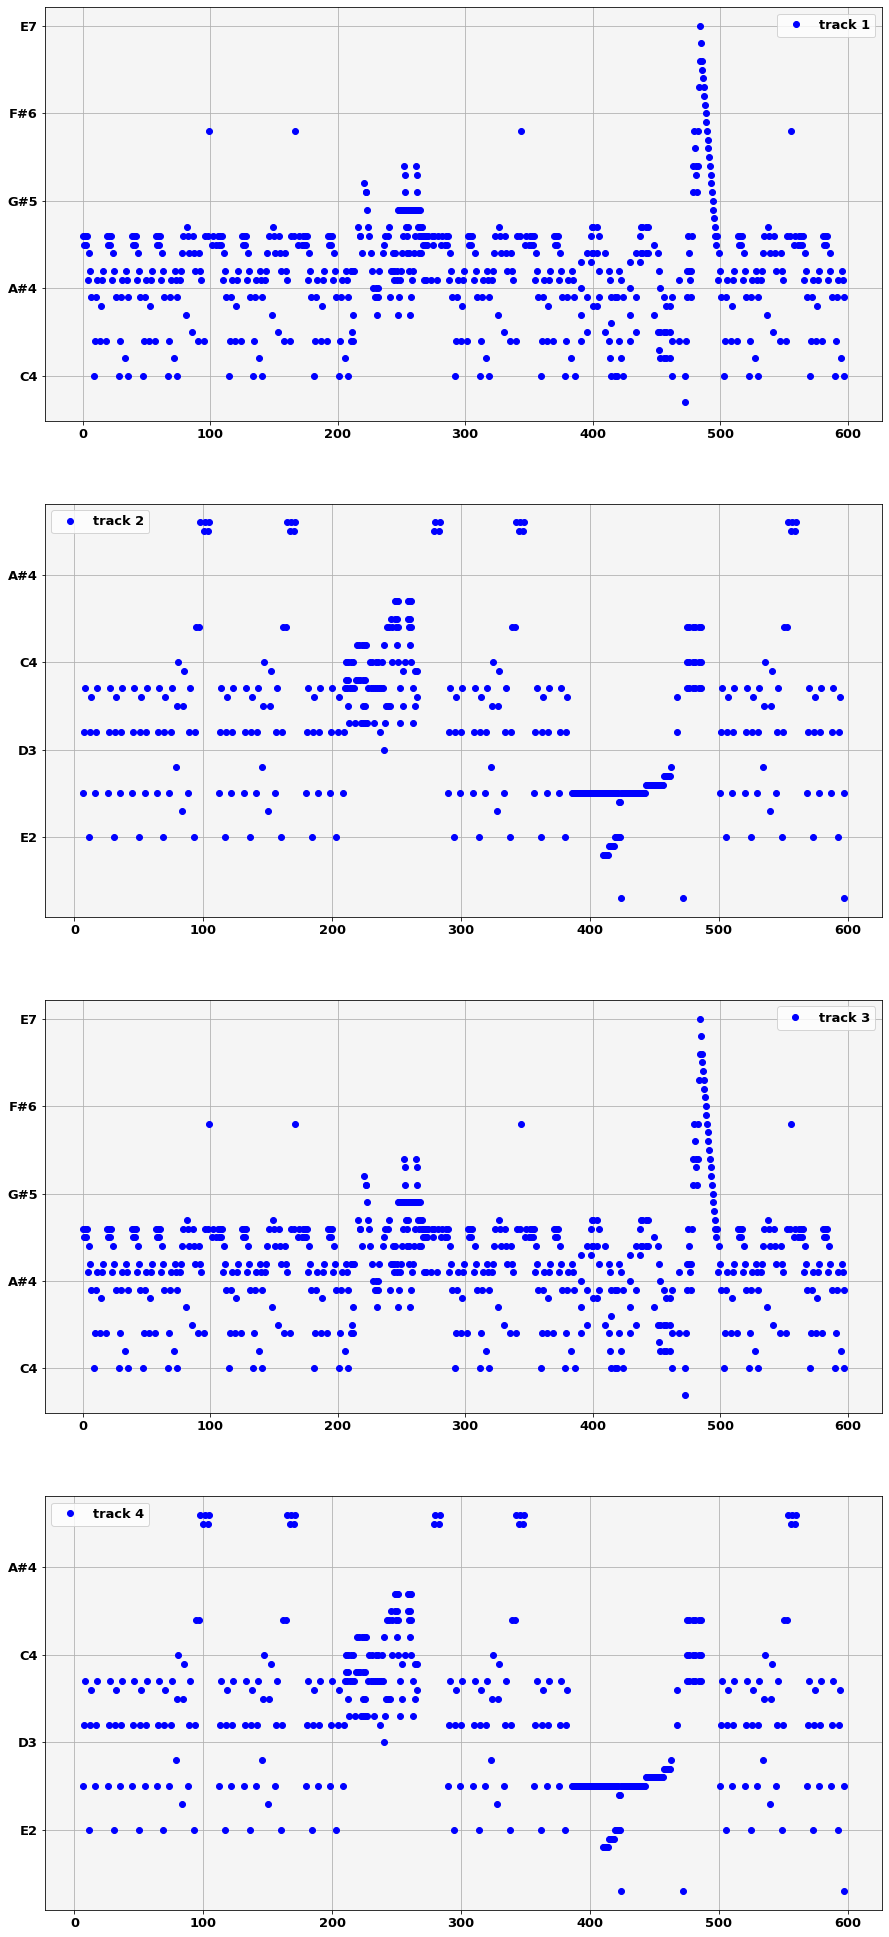

In [22]:
from matplotlib.ticker import FuncFormatter
import matplotlib

font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 13}

matplotlib.rc('font', **font)

def note_names(x, pos):
    'The two args are the value and tick position'
    return midi_range_map[int(x)]


formatter = FuncFormatter(note_names)


fig, ax = plt.subplots(4, 1, figsize=(15, 35))

for i in range(4):
    ax[i].plot(
        elise_df[(elise_df["type_1"] == 'note_on') & (elise_df["track"] == i + 1)]["total_time_seconds"],
        elise_df[(elise_df["type_1"] == 'note_on') & (elise_df["track"] == i + 1)]["note"],
        'bo', label=f"track {i + 1}"
    )

    ax[i].yaxis.set_major_formatter(formatter)
    ax[i].grid(True)
    ax[i].legend()
    ax[i].set_facecolor("whitesmoke")

# Transform to SMW txt for SPC conversion

In [110]:
header = """
#amk 2

#SPC
{
	#author "L. v. Beethoven / wol_e"
	#title "Für Elise"
	#game "Custom song/SMW"
	#length "auto"
	#comment ""
}

"""

print(header)


#amk 2

#SPC
{
	#author "L. v. Beethoven / wol_e"
	#title "Für Elise"
	#game "Custom song/SMW"
	#length "auto"
	#comment ""
}




In [111]:
bpm = 120 # TODO: change to use the tempo form midi file 
t = int(round(bpm * 256 / 625, 0)) # smw time formula: t = BPM * 256 / 625

channels = {}

channels[0] = f"""
#0 w255 t{t}

@9 ; piano

v255 
"""

add_channel_template = f"""
#channel_number

@9 ; piano

v255 
"""

channels

{0: '\n#0 w255 t49\n\n@9 ; piano\n\nv255 \n'}

In [113]:
def get_note_value_notation(duration_seconds, quarter_duration_seconds):
    ratio_map = {8: "1^1", 6: "1.", 4: "1", 3: "2.", 2: "2", 1.5: "4.", 1: "4", .75: "8.", .5: "8",
                 .375: "16.", .25: "16", .125: "32",
                .0625: "64", .0317: "128"}
    
    ratio = duration_seconds / quarter_duration_seconds
    
    closest_ratio = min(ratio_map, key=lambda x: abs(x - ratio))
    
    return ratio_map[closest_ratio]

def smw_note_name(note_name):
    smw_note = "o" + note_name[-1] + note_name[0].lower()
    if note_name[1] == "#":
        smw_note += "+"
    
    return smw_note

smw_df = elise_df.copy()[elise_df["type_1"] == "note_on"][
    ["track", "channel", "note", "note_name", "time", "total_time","total_time_seconds",
     "duration", "duration_seconds"]].sort_values(by=["track", "channel", "total_time"])

smw_df["end_total_seconds"] = smw_df["total_time_seconds"] + smw_df["duration_seconds"]
smw_df["smw_note_name"] = smw_df["note_name"].apply(smw_note_name)
smw_df["note_value_notation"] = smw_df["duration_seconds"].apply(
    lambda x: get_note_value_notation(x, seconds_per_beat))

smw_df

,track,channel,note,note_name,time,total_time,total_time_seconds,duration,duration_seconds,end_total_seconds,smw_note_name,note_value_notation
212,1.0,0.0,76.0,E5,4.0,16.0,0.133333,92.0,0.766667,0.900000,o5e,4
214,1.0,0.0,75.0,D#5,6.0,114.0,0.950000,94.0,0.783333,1.733333,o5d+,4
216,1.0,0.0,76.0,E5,0.0,208.0,1.733333,92.0,0.766667,2.500000,o5e,4
218,1.0,0.0,75.0,D#5,6.0,306.0,2.550000,94.0,0.783333,3.333333,o5d+,4
220,1.0,0.0,76.0,E5,2.0,402.0,3.350000,94.0,0.783333,4.133333,o5e,4
...,...,...,...,...,...,...,...,...,...,...,...,...
4876,4.0,13.0,40.0,E2,290.0,71058.0,592.150000,94.0,0.783333,592.933333,o2e,4
4878,4.0,13.0,52.0,E3,2.0,71154.0,592.950000,94.0,0.783333,593.733333,o3e,4
4880,4.0,13.0,56.0,G#3,0.0,71248.0,593.733333,92.0,0.766667,594.500000,o3g+,4
4882,4.0,13.0,33.0,A1,292.0,71632.0,596.933333,380.0,3.166667,600.100000,o1a,1


In [115]:
for i, (track, channel) in enumerate(
    smw_df[["track", "channel"]].drop_duplicates().values):
        
    channel_data = smw_df.copy()[(smw_df["track"] == track) & (smw_df["channel"] == channel)][
        ["total_time_seconds", "duration_seconds", "end_total_seconds",
         "smw_note_name", "note_value_notation"]
    ].reset_index()

    channel_string = add_channel_template.replace("channel_number", str(i + 1))
    
    channel_string += (channel_data.loc[0, "smw_note_name"] +
                       channel_data.loc[0, "note_value_notation"] + " ")
    
    for ix in channel_data.index[1:10]:
        if channel_data.loc[ix, "total_time_seconds"] >= channel_data.loc[ix - 1, "end_total_seconds"]:
            channel_string += (channel_data.loc[ix, "smw_note_name"] +
                       channel_data.loc[ix, "note_value_notation"] + " ")
    
    channels[i + 1] = channel_string
    
    
    
    #if (num%2) != 0:
        
    print(channel_string)



#1

@9 ; piano

v255 
o5e4 o5d+4 o5e4 o5d+4 o5e4 o5d4 o5c4 o4a2 o4c4 

#2

@9 ; piano

v255 
o2a4 o3e4 o3a4 o2e4 o3e4 o3g+4 o2a4 o3e4 o3a4 o2a4 

#3

@9 ; piano

v255 
o5e4 o5d+4 o5e4 o5d+4 o5e4 o4b4 o5d4 o5c4 o4a2 o4c4 

#4

@9 ; piano

v255 
o2a4 o3e4 o3a4 o2e4 o3e4 o3g+4 o2a4 o3e4 o3a4 o2a4 


In [116]:
elise_txt = header

for channel in channels.keys():
    elise_txt = elise_txt + "\n" + channels[channel]
    
print(elise_txt)


#amk 2

#SPC
{
	#author "L. v. Beethoven / wol_e"
	#title "Für Elise"
	#game "Custom song/SMW"
	#length "auto"
	#comment ""
}



#0 w255 t49

@9 ; piano

v255 


#1

@9 ; piano

v255 
o5e4 o5d+4 o5e4 o5d+4 o5e4 o5d4 o5c4 o4a2 o4c4 

#2

@9 ; piano

v255 
o2a4 o3e4 o3a4 o2e4 o3e4 o3g+4 o2a4 o3e4 o3a4 o2a4 

#3

@9 ; piano

v255 
o5e4 o5d+4 o5e4 o5d+4 o5e4 o4b4 o5d4 o5c4 o4a2 o4c4 

#4

@9 ; piano

v255 
o2a4 o3e4 o3a4 o2e4 o3e4 o3g+4 o2a4 o3e4 o3a4 o2a4 


In [117]:
with open("src/data/txt_output_examples/für_elise.txt", "w") as text_file:
    print(elise_txt, file=text_file)

In [ ]:
"""
TODO:  
    - Add rests (base starts immediately, that's wrong)
    - Align total duration of channesl (had to add rests so that it actually plays anything)
"""